In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('/Users/ff/dev/MSc/CX_Path_Integration')

In [2]:
from brian2 import *
from brian2tools import *
from brian2modelfitting import *

import matplotlib.pyplot as plt

import trials
import plotter

import cx_spiking.plotting
import cx_spiking.inputs

WARNING    /Users/ff/.pyenv/versions/3.8.2/envs/py_msc/lib/python3.8/site-packages/brian2modelfitting/utils.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
 [py.warnings]
  from tqdm.autonotebook import tqdm



In [3]:
# Constants
N_TL2 = 16
N_CL1 = 16
N_TB1 = 8
N_TN2 = 2

In [4]:
route_file = 'data/route.npz'
T_outbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings, digitized = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)

Load route from data/route.npz
data/route.npz exists - not overwriting it


In [31]:
start_scope()

time_step = 20 # ms

h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')
#P_HEADING_2 = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')

SPM_HEADING = SpikeMonitor(P_HEADING)

f_stimulus = TimedArray(flow*Hz, dt=1.*time_step*ms)
P_FLOW = PoissonGroup(N_TN2, rates='f_stimulus(t,i)')
SPM_FLOW = SpikeMonitor(P_FLOW)

In [32]:
# Neuron specification
EL = -52 * mV # resting potential (mV)
Vt = -45 * mV # spike threshold (mV)
Vr = -52 * mV # reset potential (mV)

Cm = 0.002 * ufarad # membrane capacitance (uF)
Rm = 10 * Mohm      # membrane resistance (MOhm)
taum = Cm * Rm      # = 20ms membrane time constant (ms) 

#ge = 0 * mV # excitatory synaptic conductance ()
#gi = 0 * mV # inhibitory synaptic conductance ()
tauE = 4.659379464230876 * ms # excitatory synaptic time constant (ms)
tauI = 1.0338063572955791 * ms # inhibitory synaptic time constant (ms)

# Synaptic weights from https://brian2.readthedocs.io/en/stable/examples/CUBA.html
#we = 12*(60 * 0.27 / 10) * mV
#wi = 12*(20 * 4.5 / 10) * mV
mult = 60
wE = 470.212326626203*nS  # excitatory synaptic weight
wI = 414.9582597606719*nS  # inhibitory synaptic weight

#4.659379464230876, 1.0338063572955791, 470.212326626203, 414.9582597606719

eqs = '''
      dVm/dt = (gL * (EL - Vm) + gE * (EE - Vm) + gI * (EI - Vm)) / Cm : volt
      dgE/dt = -gE/tauE : siemens
      dgI/dt = -gI/tauI : siemens
      EL : volt
      EE : volt
      EI : volt
      gL : siemens
      #tauE : second
      #tauI : second
      '''
threshold_eqs = 'Vm >= Vt'
reset_eqs = 'Vm = Vr'

#'Cm' : [Cm],
#'EL' : [EL],
params = {'EL' : [EL],
          'Vm' : [EL],
          'EE' : [0*mV],
          'EI' : [-80*mV],
          'gL' : [1*10**-6 * siemens],
          'gE' : '(randn() * 1.5 + 4) * 10.*nS',
          'gI' : '(randn() * 12 + 20) * 10.*nS',
          #'tauE' : [1*ms],
          #'tauI' : [2*ms]
         }

def generate_neuron_groups(N, eqs, threshold_eqs, reset_eqs, 
                           params, method='euler'):
    ng = NeuronGroup(N=N, model=eqs, threshold=threshold_eqs, reset=reset_eqs, method='euler')
    ng.set_states(params)
    return ng

G_TL2 = generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, params)
#G_CL1 = generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, params)
#G_TB1 = generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, params)
#G_TN2  generate_neuron_groups(N_TN2, eqs, threshold_eqs, reset_eqs, params)

In [33]:
def add_monitors(NG, variables_to_record=['Vm', 'gE', 'gI']):
    state_monitor = StateMonitor(NG, variables_to_record, record=True)
    spike_monitor = SpikeMonitor(NG)
    return state_monitor, spike_monitor

STM_TL2, SPM_TL2 = add_monitors(G_TL2)
#STM_CL1, SPM_CL1 = add_monitors(G_CL1)
#STM_TB1, SPM_TB1 = add_monitors(G_TB1)
#STM_TN2, SPM_TN2 = add_monitors(G_TN2)

In [34]:
def connect_synapses(G_source, G_target, W_matrix, model, on_pre, plot_name=None):
    # The connectivity matrix defined by Thomas Stone has sources on 
    # the rows and targets on the columns whereas Brian2 expects 
    # the opposite So you need to transpose it!
    sources, targets = W_matrix.T.nonzero()
    synapses = Synapses(G_source, G_target, model=model, on_pre=on_pre)
    synapses.connect(i=sources, j=targets)
    synapses.w = W_matrix.T[sources, targets]

    if plot_name:
        print(sources)
        print(targets)
        src.plotting.visualise_connectivity(synapses, plot_name=plot_name)
        
    return synapses

synapses_model = '''w : 1'''
synapses_eqs_ex = '''gE += wE * w'''
synapses_eqs_in = '''gI += wI * w'''

S_P_HEADING_TL2 = connect_synapses(P_HEADING, G_TL2, np.eye(N_TL2), model=synapses_model, on_pre=synapses_eqs_ex)

#S_P_HEADING_TL2_2 = connect_synapses(P_HEADING_2, G_TL2, np.eye(N_TL2), model=synapses_model, on_pre=synapses_eqs_in)

### Run this for simulation

In [35]:
%%time
run(1500*time_step*ms)

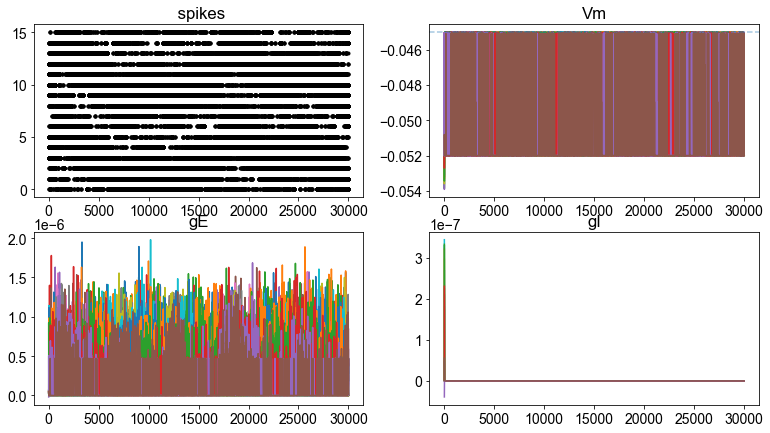

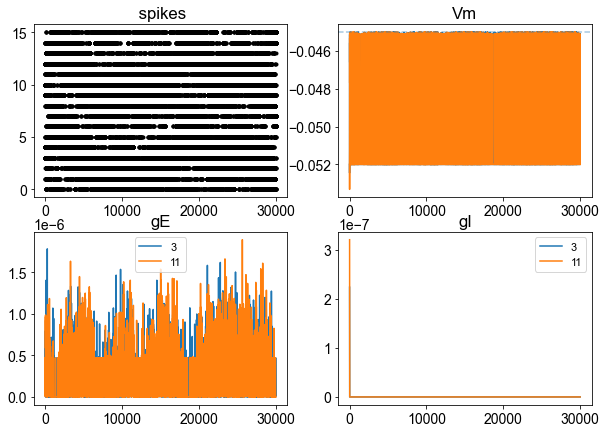

In [41]:
cx_spiking.plotting.plot_stuff(STM_TL2, SPM_TL2, observation_list=range(16), figsize=(13,7))
cx_spiking.plotting.plot_stuff(STM_TL2, SPM_TL2, observation_list=[3, 11])

### Run these for optimisation

In [18]:
store()

In [19]:
def run_simulation(tauE, tauI, wE, wI): 
    restore() 
    # set the parameters 
    tauE = tauE * ms
    tauI = tauI * ms

    wE = wE * nS
    wI = wI * nS
    
    STM_TL2, SPM_TL2 = add_monitors(G_TL2)
    
    run(100*time_step*ms)
     
    return np.sum((SPM_TL2.count - np.sum(headings[:100,:], axis=0)*0.9)**2)  # return error 

In [20]:
import nevergrad as ng

bounds = [[0,5], # tauE
          [0,5], # tauI
          [200,500], # wE
          [200,500]] # wI

instruments = []
for bound in range(len(bounds)):
    assert len(bounds[bound]) == 2
    instrumentation = ng.instrumentation.var.Array(1).asscalar().bounded(np.array([bounds[bound][0]]),
                                                           np.array([bounds[bound][1]]))
    instruments.append(instrumentation)

instrum = ng.instrumentation.Instrumentation(*instruments)

In [22]:
optim = ng.optimization.registry['DE'](instrumentation=instrum, budget=100)

recommendation = optim.minimize(run_simulation, verbosity=1)  # best value
print(optim.provide_recommendation())

Launching 1 jobs with new suggestions
Updating fitness with value 301626900.31841403
99 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value 304798424.18820965
98 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value 332206901.68676305
97 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value 344714344.7263197
96 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value 350186230.55642766
95 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value 347187080.63619673
94 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value 351314949.8733571
93 remaining budget and 0 running jobs
Launching 1 jobs with new suggestions
Updating fitness with value 320356231.3541555
92 remaining budget and 0 running jobs
Launching 1

Candidate(args=(4.706956858504094, 1.1418917396694406, 477.1972126559419, 390.3711970927966), kwargs={}, data=[ 5.36959566 -1.14599433  4.10787504  0.4498945 ])

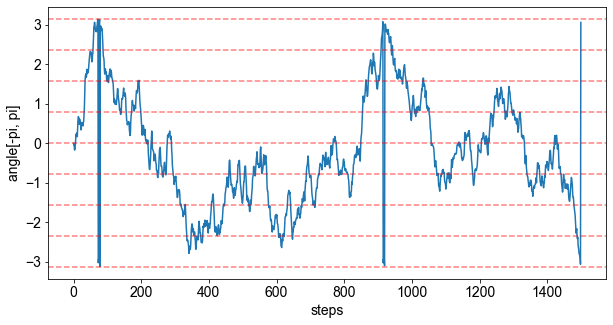

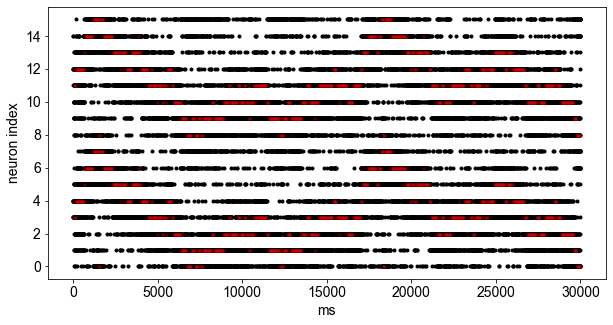

In [38]:
cx_spiking.plotting.plot_heading(h, headings, SPM_HEADING, T_outbound, time_step)